In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.

set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### 스트리밍 모드

`graph` 의 전체 상태를 스트리밍 하는 방법입니다.  
  
주요 모드는 다음과 같습니다:
  
- values: 이 스트리밍 모드는 그래프의 값들을 스트리밍합니다. 이는 각 노드가 호출된 후의 **그래프의 전체 상태를 의미**합니다.
- updates: 이 스트리밍 모드는 그래프의 업데이트 내용을 스트리밍합니다. 이는 각 노드가 호출된 후의 **그래프 상태에 대한 업데이트를 의미**합니다.
- messages: 이 스트리밍 모드는 각 노드의 메시지를 스트리밍합니다. **이때 LLM 의 토큰 단위의 출력 스트리밍 도 가능**합니다.

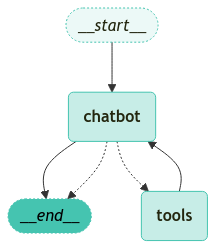

In [9]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from graphs import visualize_graph
from tools_news import GoogleNews


##### 1. 상태(State) 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


##### 2. 도구 정의 및 바인딩
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        f'-{news["content"]}' for news in news_tool.search_by_keyword(query, k=5)
    )


tools = [search_keyword]
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools)


##### 3. 노드 추가
def chatbot(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

##### 4. 엣지 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

##### 5. 그래프 컴파일
graph = graph_builder.compile()

##### 6. 그래프 시각화
visualize_graph(graph)

##### 1. `stream_mode = "values"`

values 모드는 그래프의 전체 상태를 스트리밍합니다.

**참고**   

`chunk.items()`
- key : state 의 key 값
- value : State 의 Key 에 대한하는 value

##### 동기(Synchronous) 방식의 스트리밍
- `chunk` 는 dictionary 형태 (key: State 의 key, value: State 의 value)

In [10]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="values")
for chunk in graph.stream(inputs, stream_mode="values"):

    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_gaGskHQDjodl4WqRDpZDJnIK)
 Call ID: call_gaGskHQDjodl4WqRDpZDJnIK
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제
================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
4. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!


##### 비동기(Asynchronous) 방식의 스트리밍

**참고**   
- `astream()`: 메서드는 비동기 스트림 처리를 통해 그래프를 실행하고 값 모드로 청크 단위 응답을 생성합니다.
- `async for`: 문을 사용하여 비동기 스트림 처리를 수행합니다.

In [11]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    # chunk 는 dictionary 형태(key: State 의 key, value: State 의 value)
    for state_key, state_value in chunk.items():
        if state_key == "messages":
            state_value[-1].pretty_print()

================================ Human Message =================================

AI 관련된 최신 뉴스를 검색해줘
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_ctNqZZ90RxZei196KBltJDQB)
 Call ID: call_ctNqZZ90RxZei196KBltJDQB
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제
================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
4. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!


아래는 최종 결과만 확인하고 싶은 경우에 대한 예시입니다.

In [5]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

final_result = None

# 비동기 스트림 처리(stream_mode="values")
async for chunk in graph.astream(inputs, stream_mode="values"):
    final_result = chunk

# 최종 결과 출력
print(final_result["messages"][-1].content)

다음은 AI 관련 최신 뉴스입니다:

1. **소라 출시 후 달라진 분위기**: "동영상 AI는 위협적 존재 아니야" - AI타임스
2. **정부전용 AI 플랫폼 개발**: 새해 1분기 사업자 선정 - 전자신문
3. **AI 영화에 대한 실망**: ‘나야 문희’와 ‘엠호텔’ - 조선일보
4. **이창용 발언**: "AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력" - 이투데이
5. **한은 총재 발언**: "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스

더 궁금한 내용이 있으면 말씀해 주세요!


##### 2. `stream_mode = "updates"`

updates 모드는 그래프의 업데이트 내용을 스트리밍합니다.

**참고**   

`chunk.items()`
- key : 노드의 이름
- value : 해당 노드 단계에서의 출력 값, 즉, 여러개의 key-value 쌍을 가진 dict 입니다.

##### 동기(Synchronous) 방식의 스트리밍


In [12]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="updates")
for chunk in graph.stream(inputs, stream_mode="updates"):
    # chunk 는 dictionary 형태(key: 노드, value: 노드의 상태 값)
    for node, value in chunk.items():
        if node:
            print(f"\n[Node: {node}]\n")
        if "messages" in value:
            value["messages"][-1].pretty_print()


[Node: chatbot]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_EINWAaDWpWdLNTFvEMtBz5XB)
 Call ID: call_EINWAaDWpWdLNTFvEMtBz5XB
  Args:
    query: AI

[Node: tools]

================================= Tool Message =================================
Name: search_keyword

-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제

[Node: chatbot]

================================== Ai Message ==================================

다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
4. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!


##### 비동기(Asynchronous) 방식의 스트리밍

In [13]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
async for chunk_msg, metadata in graph.astream(inputs, stream_mode="messages"):
    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)

-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제
다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
4. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!

##### 3. `stream_mode = "messages"`

messages 모드는 각 노드의 메시지를 스트리밍합니다.

**참고**   
- `chunk_msg`: 실시간 출력 메시지입니다.
- `metadata`: 노드의 정보입니다.

##### 동기(Synchronous) 방식의 스트리밍

In [14]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):

    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)

    else:
        print(chunk_msg.content)
        print(f"\n\nmetadata: \n{metadata}\n\n")

-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
-한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제


metadata: 
{'langgraph_step': 2, 'langgraph_node': 'tools', 'langgraph_triggers': ['branch:chatbot:tools_condition:tools'], 'langgraph_path': ('__pregel_pull', 'tools'), 'langgraph_checkpoint_ns': 'tools:b3990b2a-25e1-e314-ba36-f699fcb0eb71'}


다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!

##### 비동기(Asynchronous) 방식의 스트리밍

In [16]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 스트림 처리(stream_mode="messages")
# chunk_msg: 실시간 출력 메시지, metadata: 노드 정보
async for chunk_msg, metadata in graph.astream(inputs, stream_mode="messages"):
    # chatbot 노드에서 출력된 메시지만 출력
    if metadata["langgraph_node"] == "chatbot":
        if chunk_msg.content:
            print(chunk_msg.content, end="", flush=True)
    else:
        print(chunk_msg.content)

-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
-한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제
다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!

##### 특정 노드에 대한 출력 스트리밍

**참고**   
- `metadata["langgraph_node"]` 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.


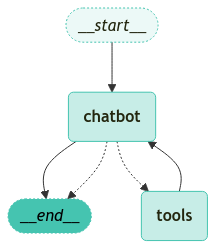

In [20]:
# 1. 상태정의
class State(TypedDict):
    messages: Annotated[list, add_messages]


# 2. 도구 노드 정의 및 바인딩
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        f'-{news["content"]}' for news in news_tool.search_by_keyword(query, k=5)
    )


# 도구 리스트 생성
tools = [search_keyword]

# llm 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


# 3. 노드 추가
def chatbot(state: State):
    return {
        "messages": [llm_with_tools.invoke(state["messages"])],
    }


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=[search_keyword])
graph_builder.add_node("tools", tool_node)

# 조건부 엣지 추가
graph_builder.add_conditional_edges("chatbot", tools_condition)

# 5. 엣지 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

# 그래프 컴파일
graph = graph_builder.compile()

# 그래프 시각화
visualize_graph(graph, xray=True)

특정 노드(Node) 에 대해서 출력하고 싶은 경우, `stream_mode="messages"` 를 통해 설정할 수 있습니다.  
  
`stream_mode="messages"` 설정시, (`chunk_msg`, `metadata`) 형태로 메시지를 받습니다.  
  
- `chunk_msg` 는 실시간 출력 메시지
- `metadata` 는 노드 정보를 의미합니다.  


`metadata["langgraph_node"]` 를 통해 특정 노드에서 출력된 메시지만 출력할 수 있습니다.  
  
(예시) chatbot 노드에서 출력된 메시지만 출력하는 경우  
  
`metadata["langgraph_node"] == "chatbot"`

In [21]:
from langchain_core.messages import HumanMessage

# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# stream_mode="messages" 를 통한 스트리밍 처리
for chunk_msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # HumanMessage 가 아닌 최종 노드의 유효한 컨텐츠만 출력 처리
    if (
        chunk_msg.content
        and not isinstance(chunk_msg, HumanMessage)
        and metadata["langgraph_node"] == "chatbot"
    ):
        print(chunk_msg.content, end="", flush=True)

다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으면 말씀해 주세요!

In [22]:
metadata

{'langgraph_step': 3,
 'langgraph_node': 'chatbot',
 'langgraph_triggers': ['tools'],
 'langgraph_path': ('__pregel_pull', 'chatbot'),
 'langgraph_checkpoint_ns': 'chatbot:8265b7fc-fce1-9a71-8bde-233c4b8c2643',
 'checkpoint_ns': 'chatbot:8265b7fc-fce1-9a71-8bde-233c4b8c2643',
 'ls_provider': 'openai',
 'ls_model_name': 'gpt-4o-mini',
 'ls_model_type': 'chat',
 'ls_temperature': 0.0}

##### 사용자 정의 tag 필터링 된 스트리밍

**tag 가 있는 llm 결과를 출력할 때는 `astream_events` 를 사용해야 합니다.**

LLM 의 출력이 여러 군데에서 발생하는 경우, 특정 노드에서 출력된 메시지만 출력하고 싶은 경우가 있습니다.  
  
이러한 경우, `tags` 를 추가하여 출력하고 싶은 노드만 선별할 수 있습니다.  
  
llm 에 tags 를 추가하는 방법은 다음과 같습니다. tags 는 리스트 형태로 추가할 수 있습니다.  
  
`llm.with_config(tags=["WANT_TO_STREAM"])  `
  
이를 통해 이벤트를 더 정확하게 필터링하여 해당 모델에서 발생한 이벤트만 유지할 수 있습니다.  
  
아래 예시는 `WANT_TO_STREAM` 태그가 있는 경우만 출력하는 예시입니다.  

In [23]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 비동기 이벤트 스트림 처리(astream_events)
async for event in graph.astream_events(inputs, version="v2"):
    # 이벤트 종류와 태그 정보 추출
    kind = event["event"]
    tags = event.get("tags", [])

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    if kind == "on_chat_model_stream" and "WANT_TO_STREAM" in tags:
        # 이벤트 데이터 추출
        data = event["data"]

        # 출력 메시지
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **기대 못 미친 AI폰… "지금까지 나온 AI 기능, 별 도움 안돼"** - ZD넷 코리아
5. **정부전용 AI 플랫폼 개발…새해 1분기 사업자 선정** - 전자신문

더 궁금한 내용이 있으면 말씀해 주세요!

##### 도구 호출에 대한 스트리밍 출력

- AIMessageChunk: 실시간 토큰 단위의 출력 메시지
- tool_call_chunks: 도구 호출 청크. 만약 tool_call_chunks 가 존재하는 경우, 도구 호출 청크를 누적하여 출력합니다. (도구 토큰은 이 속성을 보고 판단하여 출력)

In [24]:
from langchain_core.messages import AIMessageChunk, HumanMessage

# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 첫 번째 메시지 처리 여부 플래그 설정
first = True

for msg, metadata in graph.stream(inputs, stream_mode="messages"):
    # 사용자 메시지가 아닌 경우의 컨텐츠 출력 처리
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

    # AI 메시지 청크 처리 및 누적
    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

        # 도구 호출 청크 존재 시 누적된 도구 호출 정보 출력
        if msg.tool_call_chunks:
            print(gathered.tool_calls[0]["args"])

{}
{}
{}
{'query': ''}
{'query': 'AI'}
{'query': 'AI'}
-AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
-'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
-한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
-기대 못 미친 AI폰… "지금까지 나온 AI 기능, 별 도움 안돼" - ZD넷 코리아
-정부전용 AI 플랫폼 개발…새해 1분기 사업자 선정 - 전자신문다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **기대 못 미친 AI폰… "지금까지 나온 AI 기능, 별 도움 안돼"** - ZD넷 코리아
5. **정부전용 AI 플랫폼 개발…새해 1분기 사업자 선정** - 전자신문

더 궁금한 내용이 있으면 말씀해 주세요!

##### Subgraphs 스트리밍 출력

이번에는 Subgraphs 를 통해 스트리밍 출력을 확인하는 방법을 알아보겠습니다.  
  
Subgraphs 는 그래프의 일부를 서브그래프로 정의하는 기능입니다.  
  
**흐름**  

- Subgraphs 에서는 기존의 최신 뉴스를 검색하는 기능을 재사용합니다.
- Parent Graph 에서는 검색된 최신 뉴스를 바탕으로 SNS 포스트를 생성하는 기능을 추가합니다.

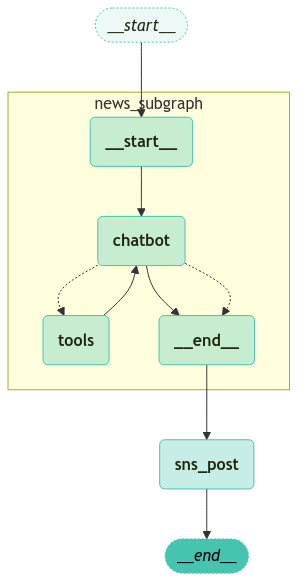

In [26]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain.tools import tool
from tools_news import GoogleNews
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return "\n".join(
        [f'- {news["content"]}' for news in news_tool.search_by_keyword(query, k=5)]
    )


# 도구 리스트 생성
tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합 (tags 추가)
llm_with_tools = llm.bind_tools(tools).with_config(tags=["WANT_TO_STREAM"])


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# SNS 포스트 생성 함수 정의
def create_sns_post(state: State):
    # SNS 포스트 생성을 위한 프롬프트
    sns_prompt = """
    이전 대화 내용을 바탕으로 SNS 게시글 형식으로 변환해주세요.
    다음 형식을 따라주세요:
    - 해시태그 포함
    - 이모지 사용
    - 간결하고 흥미로운 문체 사용
    - 200자 이내로 작성
    """
    messages = state["messages"] + [("human", sns_prompt)]
    sns_llm = ChatOpenAI(model="gpt-4o-mini").with_config(tags=["WANT_TO_STREAM2"])
    return {"messages": [sns_llm.invoke(messages)]}


# 서브그래프 생성
def create_subgraph():
    # 서브그래프용 상태 그래프 생성
    subgraph = StateGraph(State)

    # 챗봇 노드 추가
    subgraph.add_node("chatbot", chatbot)

    # 도구 노드 생성 및 추가
    tool_node = ToolNode(tools=[search_keyword])
    subgraph.add_node("tools", tool_node)

    # 조건부 엣지 추가
    subgraph.add_conditional_edges(
        "chatbot",
        tools_condition,
    )

    # tools > chatbot
    subgraph.add_edge("tools", "chatbot")

    # START > chatbot
    subgraph.add_edge(START, "chatbot")

    # chatbot > END
    subgraph.add_edge("chatbot", END)

    return subgraph.compile()


# 메인 그래프 생성
graph_builder = StateGraph(State)

# 서브그래프 추가
subgraph = create_subgraph()
graph_builder.add_node("news_subgraph", subgraph)

# SNS 포스트 생성 노드 추가
graph_builder.add_node("sns_post", create_sns_post)

# START > news_subgraph
graph_builder.add_edge(START, "news_subgraph")

# news_subgraph > sns_post
graph_builder.add_edge("news_subgraph", "sns_post")

# sns_post > END
graph_builder.add_edge("sns_post", END)

# 그래프 컴파일
graph = graph_builder.compile()

# 그래프 시각화
visualize_graph(graph, xray=True)

##### Subgraphs 출력을 '생략' 하는 경우

In [27]:
# 질문 입력
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}

# 노드 업데이트 정보 순차적 처리 및 출력
for chunk in graph.stream(inputs, stream_mode="updates"):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        # 현재 처리 중인 노드 구분선 출력
        print(f"\n========= Update from node {node_name} =========\n")
        # 해당 노드의 업데이트된 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)


========= Update from node news_subgraph =========

================================== Ai Message ==================================

다음은 AI와 관련된 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

이 뉴스들은 AI 기술이 경제, 금융 및 서비스 산업에 미치는 영향을 다루고 있습니다.

========= Update from node sns_post =========

================================== Ai Message ==================================

🌟 AI의 시대가 도래했습니다! 🚀 한국은행 총재는 AI가 금융시장 리스크 감지 시스템 개발에 중요한 역할을 할 것이라고 밝혔습니다. 💡 또한, AI 소프트웨어가 한국 서비스 수출의 새로운 성장 동력이 될 것이라고 합니다! 🇰🇷✨ #AI #인공지능 #금융혁신 #성장동력 #한국경제


##### Subgraphs 출력도 '포함' 하는 경우

**참고**

- `subgraphs=True` 를 통해 Subgraphs 의 출력도 포함할 수 있습니다.
- (namespace, chunk) 형태로 출력됩니다.

In [28]:
# 사용자의 메시지를 딕셔너리 형태로 입력 데이터 구성
inputs = {"messages": [("human", "AI 관련된 최신 뉴스를 검색해줘")]}


# 네임스페이스 문자열을 보기 좋은 형식으로 변환하는 포맷팅 함수
def format_namespace(namespace):
    return namespace[-1].split(":")[0] if len(namespace) > 0 else "parent graph"


# subgraphs=True 를 통해 서브그래프의 출력도 포함(namespace, chunk) 형태로 출력됩니다.
for namespace, chunk in graph.stream(inputs, stream_mode="updates", subgraphs=True):
    # node_name: 현재 처리 중인 노드명, node_chunk: 해당 노드의 청크 데이터
    for node_name, node_chunk in chunk.items():
        print(
            f"\n========= Update from node [{node_name}] in [{format_namespace(namespace)}] =========\n"
        )

        # 노드의 청크 데이터 출력
        if "messages" in node_chunk:
            node_chunk["messages"][-1].pretty_print()
        else:
            print(node_chunk)


========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_Lq2KqYWLR1FM8NhiRpxUlrVM)
 Call ID: call_Lq2KqYWLR1FM8NhiRpxUlrVM
  Args:
    query: AI

========= Update from node [tools] in [news_subgraph] =========

================================= Tool Message =================================
Name: search_keyword

- AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
- '소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
- 한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
- 이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
- 한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제

========= Update from node [chatbot] in [news_subgraph] =========

================================== Ai Message ==================================

최근 AI 관련 뉴스는 다음과 같습니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 

##### Subgraphs 안에서 LLM 출력 토큰 단위 스트리밍

**참고**

- `kind` 는 이벤트 종류를 나타냅니다.
- 이벤트 종류는 `StreamEvent` 타입별 정리 에서 확인하세요!


In [29]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


kind = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= on_chat_model_start =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        # 이벤트 데이터 추출
        data = event["data"]

        # 토큰 단위의 스트리밍 출력
        if data["chunk"].content:
            print(data["chunk"].content, end="", flush=True)

    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= on_chat_model_start =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
- '소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
- 한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
- 이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
- 한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제

========= on_chat_model_start =========

다음은 AI 관련 최신 뉴스입니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 사항이 있으시면 말씀해 주세요!
========= on_chat_model_start =========

🚀 AI의 발전이 우리 삶을 변화시키고 있어요! 💡 한은 총재는 AI가 금융 리스크 감지와 한국 서비스 수출의 새로운 성장 동력이 될 것이라고 강조했습니다. 😲 여러분은 AI의 미래를 어떻게 생각하시나요? #AI #미래기술 #성장엔진 #금융혁신

##### 특정 tags 만 스트리밍 출력하는 경우
- `ONLY_STREAM_TAGS` 를 통해 스트리밍 출력하고 싶은 tags 만 설정할 수 있습니다.
- 여기서는 "WANT_TO_STREAM" 는 출력에서 배제하고 "WANT_TO_STREAM2" 만 출력하는 경우를 확인합니다.

In [30]:
# 네임스페이스 정보를 파싱하는 함수
def parse_namespace_info(info: tuple) -> tuple[str, str]:
    if len(info) > 1:
        namespace, node_name = info
        return node_name.split(":")[0], namespace.split(":")[0]
    return info[0].split(":")[0], "parent graph"


# 스트리밍 출력하고 싶은 tags 만 설정 (여기서는 "WANT_TO_STREAM" 는 출력에서 배제)
ONLY_STREAM_TAGS = ["WANT_TO_STREAM"]

kind = None
tags = None

async for event in graph.astream_events(inputs, version="v2", subgraphs=True):
    kind = event["event"]
    tags = event.get("tags", [])

    # 이벤트 종류와 태그 정보 추출
    if kind == "on_chat_model_start":
        print(f"\n========= tags: {tags} =========\n")

    # 채팅 모델 스트림 이벤트 및 최종 노드 태그 필터링
    elif kind == "on_chat_model_stream":
        for tag in tags:
            if tag in ONLY_STREAM_TAGS:
                # 이벤트 데이터 추출
                data = event["data"]

                # 출력 메시지
                if data["chunk"].content:
                    print(data["chunk"].content, end="", flush=True)
    elif kind == "on_tool_start":
        print(f"\n========= tool_start =========\n")
        data = event["data"]
        if "input" in data:
            tool_msg = data["input"]
            print(tool_msg)

    elif kind == "on_tool_end":
        print(f"\n========= tool_end =========\n")
        data = event["data"]
        if "output" in data:
            tool_msg = data["output"]
            print(tool_msg.content)


========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========


========= tool_start =========

{'query': 'AI'}

========= tool_end =========

- AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단 - 조선일보
- '소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야" - AI타임스
- 한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중" - 연합뉴스
- 이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력” - 이투데이
- 한은 총재 “AI, 한국의 새로운 성장엔진 될 것” - 헤럴드경제

========= tags: ['seq:step:1', 'WANT_TO_STREAM'] =========

최신 AI 관련 뉴스는 다음과 같습니다:

1. **AI에 돈 쓰느라 직원들 공짜 마사지·공짜 밥 중단** - 조선일보
2. **'소라' 출시 후 달라진 분위기..."동영상 AI는 위협적 존재 아니야"** - AI타임스
3. **한은 총재 "AI로 금융시장 리스크 감지하는 시스템 개발 중"** - 연합뉴스
4. **이창용 “AI 소프트웨어, 韓 서비스 수출의 새로운 성장 동력”** - 이투데이
5. **한은 총재 “AI, 한국의 새로운 성장엔진 될 것”** - 헤럴드경제

더 궁금한 내용이 있으시면 말씀해 주세요!
========= tags: ['seq:step:1', 'WANT_TO_STREAM2'] =========

